In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Plot some common activation functions

In [2]:
# sigmoid and logit function 
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def ReLU(x):
    return np.maximum(0,x)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

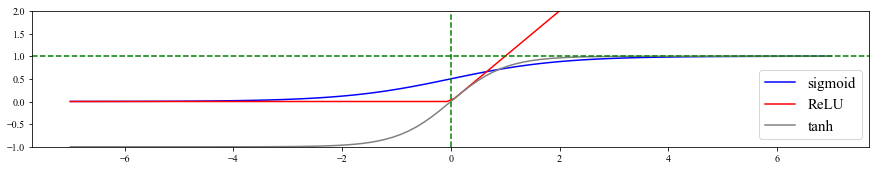

In [3]:
# plot sigmoid function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,2.5])
x = np.linspace(-7, 7, 100)
ax.plot(x, sigmoid(x), color='blue', label="sigmoid")
ax.plot(x, ReLU(x), color='red', label="ReLU")
ax.plot(x, tanh(x), color='gray', label="tanh")
ax.set_ylim(-1,2)

plt.axhline(y=1, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
ax.legend(fontsize=15)
plt.savefig('activation.pdf', bbox_inches='tight')

## Define Class FFNN 

## Classifying MNIST images using FFNN

In [4]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [5]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [6]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [846]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [863]:
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=[X,y])

# train_size = X_train.shape[0]

train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]
y_train0 = y_train[idx]

"""
NN = FFNN(list_hidden_layer_sizes = [], # hidden1, hidden2, .. , hidden h
                     loss_function = 'softmax-cross-entropy', #'softmax-cross-entropy', # 'cross-entropy' or 'square'
                     activation_list = None, # ['ReLU', 'sigmoid'],
                     node_states = None,
                     weight_matrices = None,
                     training_set = [X_train0.T/400, y_train0.T]) # input = [N x ], output 
print('NN.list_layer_sizes', NN.list_layer_sizes)
print('NN.training_set[0]', NN.training_set[0].shape)
"""
NN = MLP(M = 10, training_set = [X_train0.T/400, y_train0.T])

NN.train(n_iter=20)

y_pred_test = NN.predict(X_test.T/100, normalize=True)

y_test_label = np.asarray(onehot2list(y_test))

P_pred_test = y_pred_test[1,:]

results_dict_test = compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred_test, use_opt_threshold=False, verbose=True)


100%|██████████| 14780/14780 [00:00<00:00, 597505.69it/s]


X_train.shape (784, 100)
Y_train.shape (2, 100)
X_ext.shape (785, 100)
W0.shape (785, 10)
W1.shape (11, 2)
SGD epoch = 0, train_loss=31.068686
SGD epoch = 1, train_loss=51.999353
SGD epoch = 2, train_loss=51.999325
SGD epoch = 3, train_loss=51.997055
SGD epoch = 4, train_loss=51.990470
SGD epoch = 5, train_loss=51.990387
SGD epoch = 6, train_loss=51.990311
SGD epoch = 7, train_loss=51.990240
SGD epoch = 8, train_loss=51.990172
SGD epoch = 9, train_loss=51.990109
SGD epoch = 10, train_loss=51.990048
SGD epoch = 11, train_loss=51.989990
SGD epoch = 12, train_loss=51.989934
SGD epoch = 13, train_loss=51.989880
SGD epoch = 14, train_loss=51.989827
SGD epoch = 15, train_loss=51.989776
SGD epoch = 16, train_loss=51.989727
SGD epoch = 17, train_loss=51.989679
SGD epoch = 18, train_loss=51.989632
SGD epoch = 19, train_loss=51.989587
AUC ===> 0.009
Opt_threshold ===> 1.000
Accuracy ===> 0.463
Sensitivity ===> 1.000
Specificity ===> 0.000
Precision ===> nan
Fall_out ===> 0.000
Miss_rate ===> 1.0

<ipython-input-846-3b653028e318>:30: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [ ]:
# compute binary classification metrics on test data

M_list = [1, 5, 10, 20]
accuracy_list_test = []
accuracy_list_train = []

for M in M_list:
    NN = FFNN(list_hidden_layer_sizes = [M], # hidden1, hidden2, .. , hidden h
                     loss_function = 'softmax-cross-entropy', # 'cross-entropy' or 'square'
                     activation_list = None, # ['ReLU', 'sigmoid'],
                     node_states = None,
                     weight_matrices = None,
                     training_set = [X_train.T/100, y_train.T]) # input = [N x ], output 

    NN.train(n_SGD_iter=40, minibatch_size=100, stopping_diff=0.01, verbose=False, L2_reg = 0)
    y_pred_train = NN.predict(X_train.T/100, normalize=True)
    y_pred_test = NN.predict(X_test.T/100, normalize=True)
    
    y_train_label = np.asarray(onehot2list(y_train))
    y_test_label = np.asarray(onehot2list(y_test))

    P_pred_train = np.asarray([p[1] for p in y_pred_train])
    P_pred_test = np.asarray([p[1] for p in y_pred_test])

    results_dict_train = compute_accuracy_metrics(Y_test=y_train_label, P_pred=P_pred_train, use_opt_threshold=False, verbose=False)
    results_dict_test = compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred_test, use_opt_threshold=False, verbose=False)
    accuracy_list_test.append(results_dict_train.get('Accuracy'))
    accuracy_list_train.append(results_dict_test.get('Accuracy'))
    
# make plot
ncols = 1
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,4])
for i in np.arange(ncols):
    ax.plot(M_list, accuracy_list_train, color='blue', label="train error")
    ax.plot(M_list, accuracy_list_test, color='red', label="test error")
    ax.set_xlabel('degree', fontsize=10)
    # ax.title.set_text("num training ex = %i, \n L2 regularizer = %.3f" % (N, alpha_list[i])) 
    ax.set_ylabel('MSE', fontsize=10)
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_ex1.pdf')


In [ ]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [ ]:
# fit multiclass logistic regression using GD

list_digits=['0', '1', '2']
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST = [X,y])

NN = FFNN(list_hidden_layer_sizes = [100], # hidden1, hidden2, .. , hidden h
                     loss_function = 'softmax-cross-entropy', # 'cross-entropy' or 'square'
                     activation_list = None, # ['ReLU', 'sigmoid'],
                     node_states = None,
                     weight_matrices = None,
                     training_set = [X_train.T/100, y_train.T]) # input = [N x ], output 

NN.train(n_SGD_iter=40, minibatch_size=100, stopping_diff=0.01, verbose=False, L2_reg = 0)
y_pred_train = np.asarray(NN.predict(X_train.T/100, normalize=True))
y_pred_test = np.asarray(NN.predict(X_test.T/100, normalize=True))

print('y_pred_test.shape', y_pred_test.shape)
print('y_test.shape', y_test.shape)



#y_train_label = np.asarray(onehot2list(y_train))
#y_test_label = np.asarray(onehot2list(y_test))

P_pred_train = np.asarray([p[1] for p in y_pred_train])
P_pred_test = np.asarray([p[1] for p in y_pred_test])

results_dict_train = multiclass_accuracy_metrics(Y_test=y_train, P_pred=y_pred_train, use_opt_threshold=False)
results_dict_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_pred_test, use_opt_threshold=False)
accuracy_list_test.append(results_dict_train.get('Accuracy'))
accuracy_list_train.append(results_dict_test.get('Accuracy'))

"""
# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_digits), figsize=[12, 4])
for i in np.arange(len(list_digits)):
    L = list_digits[i]
    im = ax[i].imshow(W[1:,i].reshape(28,28), vmin=np.min(W), vmax=np.max(W))
    ax[i].title.set_text("MLR coeff. for %s" % L )
    # ax[i].legend()
    # if i == len(list_digits) - 1:
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MLR_MNIST_ex1.pdf', bbox_inches='tight')
"""

In [72]:
X_train = np.random.rand(5,4)
X_ext = np.vstack((X_train, np.ones(X_train.shape[1])))
X_ext[:-1,:].shape

(6, 4)

In [60]:
class FFNN():

    def __init__(self,
                 list_hidden_layer_sizes = [30], # hidden1, hidden2, .. , hidden h
                 loss_function = 'softmax-cross-entropy', # or 'square' or 'cross-entropy' or 'identity'
                 activation_list = None, # ['ReLU', 'sigmoid'],
                 node_states = None,
                 weight_matrices = None,
                 training_set = [None, None]): # input = [feature_dim x samples], output [\kappa x samples]
                 
        self.training_set = training_set
        # self.test_set = test_set
        self.list_layer_sizes = [self.training_set[0].shape[0]] + list_hidden_layer_sizes + [self.training_set[1].shape[0]]        
        self.list_layer_sizes[0] += 1 # add hidden unit in the input layer. For hidden layers, the last node are the hidden units.    
        self.n_layers = len(self.list_layer_sizes)-1
        self.loss_function = loss_function
        self.activation_list = activation_list
        self.node_states = node_states
        self.weight_matrices = weight_matrices
        
        self.initialize()
        
       
    def initialize(self):
        if self.activation_list is None:
            activation_list = ['ReLU' for i in np.arange(len(self.list_layer_sizes)-1)]
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        if self.node_states == None:
            node_states = []
            for i in np.arange(len(self.list_layer_sizes)):
                node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
            self.node_states = node_states
        
        if self.weight_matrices == None:
            weight_matrices = []
            for i in np.arange(len(self.activation_list)):
                U = np.random.rand(self.list_layer_sizes[i], self.list_layer_sizes[i+1]) 
                weight_matrices.append(1-2*U)
            self.weight_matrices = weight_matrices
            print('weight_matrix.shape', U.shape)

       
    def forward_propagate(self, input_data):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0] = np.append(input_data, [1]) # 1 for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i])
            if i < self.n_layers-1:
                X_new[-1]=1 # reset state of the hidden units to 1 (output layer has no hidden unit)
            self.node_states[i+1] = X_new
        
    def backpropagate(self, output_data):
        # Backpropagate the error and return the gradient of the weight matrices
        # output_data = column array
        node_errors = self.node_states.copy()

        y = output_data
        y_hat = self.node_states[-1] # shape (\kappa, )
        y_hat = y_hat[:, np.newaxis]
        node_errors[-1] = delta_loss_function(y=y, y_hat=y_hat, type=self.loss_function)
        W_grad = self.weight_matrices.copy()
        
        for i in range(self.n_layers -1, -1, -1):
            # First weight the errors of nodes in layer above by the derivative of activation
            wtd_errors = node_errors[i+1].copy() 
            z = self.node_states[i][:,np.newaxis]
            W = self.weight_matrices[i]
            layer_size_above = self.list_layer_sizes[i+1]
            delta_activation_weights = [delta_activation(z.T @ W[:,q], type=self.activation_list[i]) for q in np.arange(layer_size_above)]
            delta_activation_weights = np.asarray(delta_activation_weights)
            if len(delta_activation_weights.shape)==1:
                delta_activation_weights = delta_activation_weights[:,np.newaxis] 
            if len(wtd_errors.shape)==1:
                wtd_errors = wtd_errors[:,np.newaxis] 
        
            wtd_errors = wtd_errors * delta_activation_weights
            # wtd_errors = wtd_errors[:, np.newaxis]

            # Compute the gradient of the i th weight matrix (conneting layer i and i+1)
            W_grad[i] = wtd_errors @ z.T  
            
            # Propagate it backward onto layer i
            node_errors[i] = (W @ wtd_errors)[:,0]
        return W_grad
    
    def minibatch_grad(self, minibatch_idx, L2_reg=0):
        
        W_grad_list = []
        Y = self.training_set[1] # true labels: each column = one-hot encoding
        X = self.training_set[0]
        for i in minibatch_idx:
            self.forward_propagate(input_data=X[:,i])
            y = Y[:, i]
            y = y[:, np.newaxis]
            W_grad = self.backpropagate(output_data=y)
            W_grad_list.append(W_grad)
            
        W_grad_minibatch = self.weight_matrices.copy()
        for j in np.arange(self.n_layers):
            grad_temp = [W_grad_list[i][j] for i in np.arange(len(minibatch_idx))]
            W_grad_minibatch[j] = np.sum(np.asarray(grad_temp), axis=0).T + L2_reg * self.weight_matrices[j]
            
        return W_grad_minibatch 
        
    def train(self, n_SGD_iter=10, minibatch_size=1, stopping_diff=0.01, verbose=False, L2_reg=0):
        Y = self.training_set[1]
        weight_matrices_new = self.weight_matrices
        for i in np.arange(n_SGD_iter):
            # compute the minibatch gradients of weight matrices 
            num_train_data = Y.shape[0]
            minibatch_idx = np.random.choice(np.arange(num_train_data), minibatch_size)
            W_grad_minibatch = self.minibatch_grad(minibatch_idx=minibatch_idx, L2_reg=L2_reg)
            
            # GD 
            
            y_hat = np.asarray(self.predict(self.training_set[0])).T
            X_train = self.training_set[0].copy()
            print('!! y_hat.shape', y_hat.shape)
            # print('!! X_train', X_train)
            
            for j in np.arange(self.n_layers):
                W1 = self.weight_matrices[j]
                t = 0
                grad = W_grad_minibatch[j]
                grad_old = grad.copy()
                
                
                if j == 1:
                    grad = np.zeros(shape=W1.shape)
                    
                    for s in np.arange(Y.shape[1]):
                        X = self.training_set[0]
                        self.forward_propagate(input_data=X[:,s])
                        print('!!y_hat', y_hat[:,s])
                        print('!! y', Y[:,s])
                        print('!! norm', np.linalg.norm(y_hat[:,s] - Y[:,s])**2)
                        a = (y_hat[:,s] - Y[:,s]).reshape(-1,1)
                        b = self.node_states[1].reshape(1,-1)
                        print('!! b', b)
                        grad = a @ b
                        print('grad', grad)
                        grad = grad.T
                        print('!!! iter', i)
                        step = (np.log(i+2) / (((i + 1) ** (0.5))))
                        W1  -= step * grad
                    # print('grad_old-grad', np.linalg.norm(grad_old-grad))
                
                if j == 0:
                    grad = np.zeros(shape=W1.shape)
                    W2 = self.weight_matrices[1]
                    for s in np.arange(Y.shape[1]):
                        X = self.training_set[0]
                        self.forward_propagate(input_data=X[:,s])
                        x = np.append(X_train[:,s],[1]).reshape(-1,1)
                        for row in np.arange(W1.shape[0]):
                            for col in np.arange(W1.shape[1]):
                                grad[row,col] += (W2[col,:]@(y_hat[:,s] - Y[:,s]))*(1-tanh(x.T @ W1[:,col])**2)*x[row,0]
                    # print('grad_old-grad', np.linalg.norm(grad_old-grad))
                    
                # if (np.linalg.norm(grad) > stopping_diff):
                        step = (np.log(i+2) / (((i + 1) ** (0.5))))
                        W1 -= step * grad
                    
                print('!!! W change', np.linalg.norm(self.weight_matrices[j]-W1))
            
                self.weight_matrices[j] = W1.copy()
                
                
                if (j == 0) and verbose:
                    y_hat = np.asarray(self.predict(self.training_set[0])).T
                    train_loss = np.sum(loss_function(y=Y, y_hat=y_hat, type=self.loss_function))
                    # print('y_hat', y_hat)
                    print('SGD epoch = %i, train_loss=%f, grad_norm = %f' %(i, train_loss, np.linalg.norm(grad)))
                    #print('SGD epoch = %i, grad_norm = %f' %(i, np.linalg.norm(grad)))
                   
                    #y_train = np.asarray(onehot2list(Y.T))
                    #P_pred = y_hat[1,:]
                    
                    # print('Y-y_hat', 2*(np.linalg.norm(Y-y_hat))**2)
                    
                    # print('grad', grad.T)
                    
                    #metrics = compute_accuracy_metrics(Y_test=y_train, P_pred=P_pred, use_opt_threshold=False, verbose=False)
                    #print('Confusion matrix:\n', metrics.get('Confusion_mx') )
        
            
    def predict(self, test_set, normalize=False):
        y_pred = []
        for i in np.arange(test_set.shape[1]):
            self.forward_propagate(input_data=test_set[:,i])
            y_hat = self.node_states[-1].copy()
            if normalize:
                y_hat /= np.sum(y_hat)
            y_pred.append(y_hat)
            # print('!! y_hat', y_hat)
        return y_pred
            
        
### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(x, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return sigmoid(x)*(1-sigmoid(x))
    elif type == 'ReLU':
        return int((x>0))
    elif type == 'tanh':
        return 1-(tanh(x))**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)

def tanh(x):
    #return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    return np.tanh(x)

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

In [859]:
class MLP():
    
    # multilayer perceptron with tanh and identity activation for the hidden and output layers 
    # train with square loss 
    # M = # of hidden nodes
    # training_set = [X_train, Y_train]
    # X_train.shape = [features x samples]
    # Y_train.shape = [features x samples]
    
    def __init__(self,
                 M = 30, # number of hidden nodes (except hidden unit)
                 training_set = [None, None]): # input = [feature_dim x samples], output [\kappa x samples]
        
        self.M = M
        self.X_train = training_set[0]
        self.Y_train = training_set[1]
        
        print('X_train.shape', self.X_train.shape)
        print('Y_train.shape', self.Y_train.shape)
        
        
        # Initialize weight matrices 
        X_ext = np.vstack((self.X_train, np.ones(self.X_train.shape[1]))) # add 1 for hidden units in the input layer
        print('X_ext.shape', X_ext.shape)
        W0 = np.random.rand(self.X_train.shape[0]+1, self.M) # add one more row for bias, extra column is all zeros 
        W1 = np.random.rand(self.M+1, self.Y_train.shape[0]) # add one more row for bias
        print('W0.shape', W0.shape)
        print('W1.shape', W1.shape)
        
        self.weight_matrices = [W0, W1]
        
    def train(self, n_iter=10):
        W0 = self.weight_matrices[0]
        W1 = self.weight_matrices[1]
        
        for t in np.arange(n_iter):
            # SGD optimization 
            X_ext = np.vstack((self.X_train, np.ones(self.X_train.shape[1])))
            step = (1 / (np.log(t+2) * ((t + 10) ** (0.5))))
            grad = self.total_grad(X_ext, self.Y_train, W0, W1)
            W0  -= step * grad[0] # do not update the last column (hidden unit --> next layer)
            W1  -= step * grad[1] # do not update the last column(hidden unit --> next layer)

            self.weight_matrices = [W0, W1]

            # calculate error
            y_hat = self.predict(self.X_train)
            y = self.Y_train

            error = 0.0
            for k in range(y_hat.shape[1]):
                error += 0.5 * np.linalg.norm(y_hat[:,k] - y[:,k])**2 

            print('SGD epoch = %i, train_loss=%f' %(t, error))
        
        return [W0, W1]

    def per_sample_grad(self, x_train, y_train, W0, W1):
        # forward_propagate 
        x = x_train # input states  
        z = tanh(x.T @ W0).T # hidden states 
        z_ext = np.vstack((z, [1])) # add the hidden unit
        y_hat = sigmoid(z_ext.T @ W1).T # output states
        grad1 = (z_ext @ ((y_hat - y_train) * dsigmoid(W1.T @ z_ext)).T) 
           
        a = (W1[:-1,:] @ (y_hat - y_train))
        b = (1-z**2)  
        grad0 = x @ (a*b).T 
        return [grad0, grad1] 
    
    def total_grad(self, X_train, Y_train, W0, W1):
        grad0 = np.zeros(shape = W0.shape)
        grad1 = np.zeros(shape = W1.shape)
        for s in np.arange(X_train.shape[1]):
            x = X_train[:,s]
            y = Y_train[:,s]
            per_sample_grad = self.per_sample_grad(x[:,np.newaxis], y[:,np.newaxis], W0, W1)
            grad0 += per_sample_grad[0]
            grad1 += per_sample_grad[1]
        return [grad0, grad1]
    
            
    def predict(self, X_test, normalize = False):
        X_ext = np.vstack((X_test, np.ones(X_test.shape[1]))) # add 1 for hidden units in the input layer
        # forward_propagate 
        W0 = self.weight_matrices[0]
        W1 = self.weight_matrices[1]
        x = X_ext # input states
        z = tanh(x.T @ W0).T # hidden states 
        z = np.vstack((z, np.ones(z.shape[1]))) # add the hidden unit
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def ReLU(x):
    return np.maximum(0,x)

## Polynomial Fitting using FFNN

In [840]:
def make_poly_matrix(x, deg=5):
    # given a d-dim vector x = [x1, x2, .. xd], make a d x (M+1) matrix 
    # 1 x1 x1**2 ... x1**M
    # 1 x2 x2**2 ... x2**M
    # ..
    # 1 xd xd**2 ... xd**M
    x = np.asarray(x)
    X = [np.ones(len(x))]
    x1 = x.copy()
    for i in np.arange(deg):
        X.append(x1)
        x1 = x1 * x

    X = np.asarray(X).T # d x M matrix of input 
    # print(X.shape)
    return X

In [841]:
def poly_regression(x_train, y_train, deg=9, alpha=0):
    # fit polynomial regression of given degree with L2 regularizer alpha
    X = make_poly_matrix(x_train, deg=deg)
    w_hat = np.linalg.pinv(X.T @ X + alpha*np.identity(X.shape[1])) @ X.T @ y_train
    y_hat_train = X @ w_hat
    return y_hat_train, w_hat

In [842]:
def predict_MLP(X_test, W0, W1):
    X_ext = np.vstack((X_test, np.ones(X_test.shape[1]))) # add 1 for hidden units in the input layer
    # forward_propagate 
    print('X_test.shape', X_test.shape)
    print('W0.shape', W0.shape)
    print('W1.shape', W1.shape)
    
    
    x = X_ext # input states
    z = tanh(x.T @ W0).T # hidden states 
    z = np.vstack((z, np.ones(z.shape[1]))) # add the hidden unit
    y_hat = (z.T @ W1).T # output states
    return y_hat

x_train.shape (10,)
y_train.shape (10,)


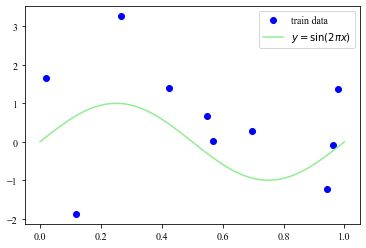

In [843]:
# Generate train and test data from y = sin(2\pi x) + N(0,\sigma^2)

np.random.seed(0)
N = 10
sigma = 1
x_train = []
y_train = []
x_test = []
y_test = []
for i in np.arange(N):
    U1 = np.random.rand()
    U2 = np.random.rand()
    e1 = np.random.normal(0,sigma**2)
    e2 = np.random.normal(0,sigma**2) 
    x_train.append(U1)
    x_test.append(U2)
    y_train.append(np.sin(2*np.pi*U1)+e1)
    y_test.append(np.sin(2*np.pi*U2)+e2)
    
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)



# make plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_train, y_train, 'o', color='blue', label="train data")
x = np.linspace(0, 1, 100)
ax.plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")
ax.legend()

In [844]:
M = 1
MM = MLP(M = M, training_set = [x_train[np.newaxis,:], y_train[np.newaxis,:]])

X_train.shape (1, 10)
Y_train.shape (1, 10)
X_ext.shape (2, 10)
W0.shape (2, 1)
W1.shape (2, 1)


SGD epoch = 0, train_loss=9.930311
train_loss=%f 9.930310547631604
SGD epoch = 1, train_loss=9.925217
train_loss=%f 9.925216967134594
SGD epoch = 2, train_loss=9.921553
train_loss=%f 9.921553184276167
SGD epoch = 3, train_loss=9.918620
train_loss=%f 9.91862033168566
SGD epoch = 4, train_loss=9.916139
train_loss=%f 9.916139334729396
SGD epoch = 5, train_loss=9.913969
train_loss=%f 9.913968695749885
SGD epoch = 6, train_loss=9.912026
train_loss=%f 9.912025910454082
SGD epoch = 7, train_loss=9.910258
train_loss=%f 9.910258227922274
SGD epoch = 8, train_loss=9.908630
train_loss=%f 9.908629643670599
SGD epoch = 9, train_loss=9.907114
train_loss=%f 9.907114358125169
SGD epoch = 10, train_loss=9.905693
train_loss=%f 9.905693176494884
SGD epoch = 11, train_loss=9.904351
train_loss=%f 9.904351385528159
SGD epoch = 12, train_loss=9.903077
train_loss=%f 9.903077430669986
SGD epoch = 13, train_loss=9.901862
train_loss=%f 9.901862054296934
SGD epoch = 14, train_loss=9.900698
train_loss=%f 9.9006977

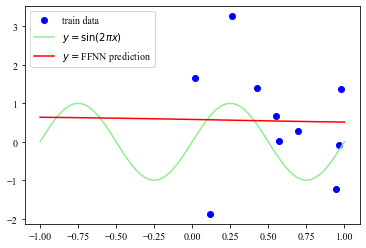

In [845]:
MM.train(n_iter = 100)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_train, y_train, 'o', color='blue', label="train data")
x = np.linspace(-1, 1, 100)
ax.plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")

y_pred = MM.predict(x[np.newaxis,:])

# y_pred = predict_MLP(x[np.newaxis,:], W0, W1)

ax.plot(x, y_pred[0,:], color='red', label="$y=$FFNN prediction")
ax.legend()

In [684]:
# H_train = np.vstack((np.ones(len(x_train)), x_train[np.newaxis,:]))


# print('H_train', H_train)

NN_sin = FFNN(list_hidden_layer_sizes = [2], # hidden1, hidden2, .. , hidden h
          activation_list = ['tanh', 'identity'], # ['tanh', 'identity'],
         loss_function = 'square', # or 'softmax-cross-entropy' or 'square'
         training_set = [x_train[np.newaxis,:], y_train[np.newaxis,:]]) # input = [feature_dim x samples], output [\kappa x samples]
print('NN.list_layer_sizes', NN_sin.list_layer_sizes)
print('NN.list_layer_sizes', NN_sin.weight_matrices[0].shape)
print('NN.list_layer_sizes', NN_sin.weight_matrices[1].shape)

weight_matrix.shape (2, 1)
NN.list_layer_sizes [2, 2, 1]
NN.list_layer_sizes (2, 2)
NN.list_layer_sizes (2, 1)


!! y_hat.shape (1, 10)
!!! W change 0.0
SGD epoch = 0, train_loss=6.192620, grad_norm = 13.761052
!!y_hat [-0.08175324]
!! y [0.45052976]
!! norm 0.28332519301919684
!! b [[1. 1.]]
grad [[-0.532283 -0.532283]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [0.76112754]
!! norm 0.7104480010427754
!! b [[1. 1.]]
grad [[-0.84288078 -0.84288078]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [1.09091753]
!! norm 1.375156742309984
!! b [[1. 1.]]
grad [[-1.17267077 -1.17267077]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [0.87409992]
!! norm 0.9136552680057425
!! b [[1. 1.]]
grad [[-0.95585316 -0.95585316]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [-0.71642662]
!! norm 0.40281030392017214
!! b [[1. 1.]]
grad [[0.63467338 0.63467338]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [-0.36056724]
!! norm 0.07773724900836802
!! b [[1. 1.]]
grad [[0.278814 0.278814]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [-0.84038207]
!! norm 0.5755177030401628
!! b [[1. 1.]]
grad [[0.75862883 0.75862883]]
!!! iter 0
!!y_hat [-0.08175324]
!! y [0

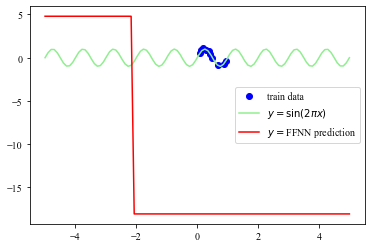

In [282]:
NN_sin.train(n_SGD_iter=2, minibatch_size=100, stopping_diff=0.001, verbose=True, L2_reg=0.1)
# make plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_train, y_train, 'o', color='blue', label="train data")
x = np.linspace(0, 5, 100)
ax.plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")

# H_test = np.vstack((np.ones(len(x)), x[np.newaxis,:]))

y_pred = NN_sin.predict(x[np.newaxis,:], normalize=False)

ax.plot(x, y_pred, color='red', label="$y=$FFNN prediction")
ax.legend()

In [ ]:
# plot fitted polynomial regression curve
deg_list = [1,4,9] # degree of polynomial 
alpha_list = [0, 0, 0.01, 0.1]
fig, ax = plt.subplots(nrows=1, ncols=len(deg_list), figsize=[16, 4])
for i in np.arange(len(deg_list)):
    # make plot
    M = deg_list[i]
    alpha = alpha_list[1]
    ax[i].plot(x_train, y_train, 'o', color='blue', label="train data")
    x = np.linspace(0, 1, 100)
    ax[i].plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")
    
    NN_sin = FFNN(list_hidden_layer_sizes = [10], # hidden1, hidden2, .. , hidden h
              activation_list = ['tanh', 'identity'], # For regression problems, should not use sigmoid in the last layer
             loss_function = 'square', # or 'softmax-cross-entropy' or 'square'
             training_set = [x_train[np.newaxis,:], y_train[np.newaxis,:]]) # input = [feature_dim x samples], output [\kappa x samples]

    NN_sin.train(n_SGD_iter=40, minibatch_size=100, stopping_diff=0.01, verbose=False)
    y_pred = NN_sin.predict(x[np.newaxis,:], normalize=False)
    # y_hat_train, w_hat = poly_regression(x_train, y_train, deg=M, alpha=alpha)
    # ax.plot(x_train, y_hat_train, 'o', color = 'red')
    # y_poly = make_poly_matrix(x, deg=M) @ w_hat
    
    ax[i].plot(x, y_pred, color = 'red', label="poly regression w/ deg %i" % M)
    ax[i].title.set_text("num training ex = %i, \n L2 regularizer = %.3f" % (N, alpha)) 
    ax[i].legend()
    plt.savefig('poly_fitting_ex_2.pdf', bbox_inches='tight')
    

In [ ]:
# plot the test error for multiple values of hyperparameters 

deg_list = np.arange(1,10)
alpha_list = [0, 0.001, 0.01, 0.1, 1]
error_train_mx = np.zeros(shape=[len(deg_list), len(alpha_list)])
error_test_mx = np.zeros(shape=[len(deg_list), len(alpha_list)])

for i in np.arange(len(deg_list)):
    for j in np.arange(len(alpha_list)):
        y_hat_train, w_hat = poly_regression(x_train, y_train, deg=deg_list[i], alpha=alpha_list[j])
        y_hat_test = make_poly_matrix(x_test, deg=deg_list[i]) @ w_hat
        error_train_mx[i, j] = np.linalg.norm(y_train-y_hat_train, 2)**2/N
        error_test_mx[i, j] = np.linalg.norm(y_test-y_hat_test, 2)**2/N
# print('!!!', error_mx)


# make plot
ncols = 3
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,4])
for i in np.arange(ncols):
    ax[i].plot(deg_list, error_train_mx[:,i], color='blue', label="train error")
    ax[i].plot(deg_list, error_test_mx[:,i], color='red', label="test error")
    ax[i].set_xlabel('degree', fontsize=10)
    ax[i].title.set_text("num training ex = %i, \n L2 regularizer = %.3f" % (N, alpha_list[i])) 
    ax[i].set_ylabel('MSE', fontsize=10)
    ax[i].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('poly_error_ex_2.pdf')